In [44]:
import pandas as pd

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


In [46]:
db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="tejas12345#",
                           database="ecommerce")
cur=db.cursor()


# List all unique cities where customers are located.            


In [47]:
query = """ select distinct customer_city from customers """

cur.execute (query)

data=cur.fetchall()

df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# the number of orders placed in 2017.

In [48]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

cur.execute (query)

data=cur.fetchall()

"Order placed in 2017:",data[0][0]

('Order placed in 2017:', 45101)

# The total sales per category

In [49]:
query = """ select products.product_category category,round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category """

cur.execute (query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Category","sales"])
df.head(10)

,Category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
5,automotive,852294.33
6,computer accessories,1585330.45
7,housewares,1094758.13
8,babies,539845.66
9,toys,619037.69


# The percentage of orders that were paid in installments

In [50]:
query = """ select (sum(case when payment_installments>1 then 1 else 0 end))/count(*)*100 
from payments"""
#here I have not considered installments greater than 1
cur.execute (query)

data=cur.fetchall()

data

[(Decimal('49.4176'),)]

# Number of customers from each state.

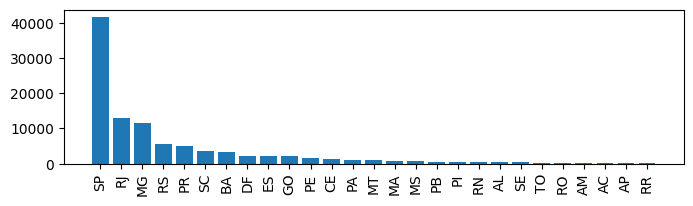

In [51]:
query = """ select customer_state,count(customer_id) from customers group by customer_state"""

cur.execute (query)

data=cur.fetchall()

df=pd.DataFrame(data,columns =["State","Customer_count"])
df=df.sort_values(by=["Customer_count"],ascending= False)
plt.figure(figsize=(8,2))
plt.bar(df["State"],df["Customer_count"])
plt.xticks(rotation=90)
plt.show()

        

# The number of orders per month in 2018.

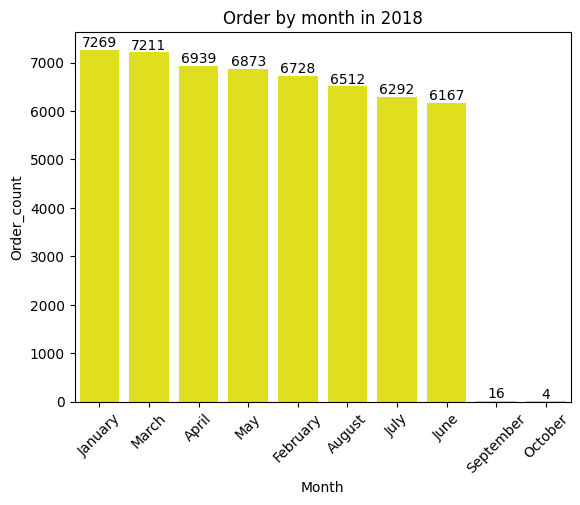

In [52]:
query= """ select monthname(order_purchase_timestamp) months ,count(order_id) order_count 
from orders where year(order_purchase_timestamp)=2018
group by months"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Month","Order_count"])
df=df.sort_values(by=["Order_count"],ascending= False)
ax=sns.barplot(x=df["Month"],y=df["Order_count"], data=df,color="Yellow")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Order by month in 2018")
plt.show()

# The average number of products per order, grouped by customer city.

In [53]:
query="""with count_per_order as
(select ecommerce.orders.order_id, ecommerce.orders.customer_id , count(ecommerce.order_items.order_id) oc
from ecommerce.orders join ecommerce.order_items
on ecommerce.orders.order_id=ecommerce.order_items.order_id
group by ecommerce.orders.order_id, ecommerce.orders.customer_id)
select ecommerce.customers.customer_city,round(avg(count_per_order.oc),2) avg_orders
from ecommerce.customers join count_per_order
on ecommerce.customers.customer_id=count_per_order.customer_id
group by ecommerce.customers.customer_city order by avg_orders desc"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["City","Avg_orders"])
df.head(5)

,City,Avg_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00


# The percentage of total revenue contributed by each product category

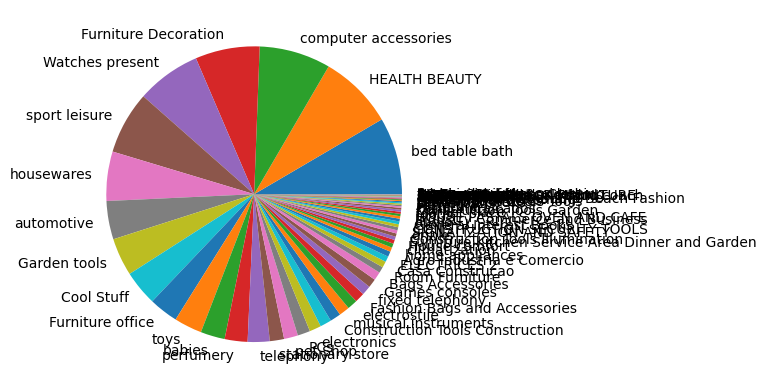

In [54]:
query="""select ecommerce.products.product_category as category,
round((sum(ecommerce.payments.payment_value)/(select sum(ecommerce.payments.payment_value) from ecommerce.payments))*100,2) as sales_percentage 
from ecommerce.products join ecommerce.order_items 
on products.product_id = order_items.product_id
join ecommerce.payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","sales_percentage"])
plt.pie(df["sales_percentage"],labels=df["Category"])
plt.show()



 # The correlation between product price and the number of times a product has been purchased.

In [55]:
query="""select ecommerce.products.product_category category, count(ecommerce.order_items.product_id) frequency, 
round(avg(ecommerce.order_items.price),2) avg_price
from ecommerce.products join ecommerce.order_items 
on ecommerce.products.product_id=ecommerce.order_items.product_id
group by category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category","order_count","price"])
df.head()


,Category,order_count,price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14


In [56]:
import numpy as np
arr1=df["order_count"]
arr2=df["price"]
a=np.corrcoef([arr1,arr2])
print("Correlation between product price and the number of times a product has been purchased is",a[0][1])

Correlation between product price and the number of times a product has been purchased is -0.10631514167157562


 # The total revenue generated by each seller, and rank them by revenue.


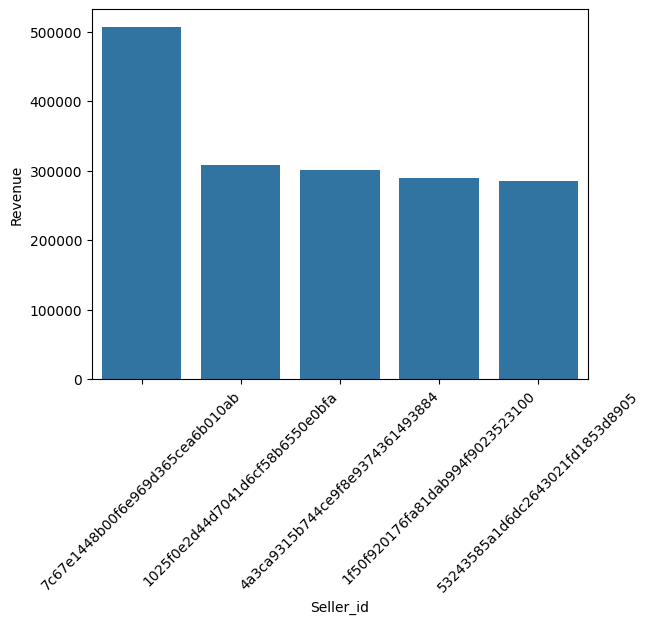

In [57]:
query="""select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id , sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Seller_id","Revenue","Rank"])
df=df.head()
sns.barplot(x="Seller_id",y="Revenue", data=df)
plt.xticks(rotation=45)
plt.show()

# The moving average of order values for each customer over their order history.

In [58]:
query="""select customer_id,order_purchase_timestamp,payments, 
avg(payments) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payments
from payments join orders
on payments.order_id=orders.order_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer_id","Order_timestamp","Payments","Moving_avg"])
df.head(20)

,Customer_id,Order_timestamp,Payments,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# The cumulative sales per month for each year

In [59]:
query="""select years, months, payment,
sum(payment) over(order by years, months) as cumulative_sales from
(select year(orders.order_purchase_timestamp) years, month(orders.order_purchase_timestamp) months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id= payments.order_id
group by years,months order by years, months) as a"""

cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# The year-over-year growth rate of total sales.

In [60]:
query="""select years, ((payments-lag(payments,1) over(order by years))/lag(payments,1) over(order by years))*100 from
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payments from orders join payments
on orders.order_id=payments.order_id 
group by years) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Year","yoy % growth"])
df


,Year,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# The retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [61]:
query= """with a as (select customers.customer_id, customers.customer_unique_id, min(orders.order_purchase_timestamp)  first_order
from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_unique_id)
select a.customer_unique_id, count(distinct orders.order_purchase_timestamp) from a
join orders on a.customer_id=orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 18 month)
group by a.customer_unique_id"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Customer_unique_id","Repetation"])
df

,Customer_unique_id,Repetation
0,00172711b30d52eea8b313a7f2cced02,1
1,004b45ec5c64187465168251cd1c9c2f,1
2,00cc12a6d8b578b8ebd21ea4e2ae8b27,1
3,011b4adcd54683b480c4d841250a987f,1
4,012452d40dafae4df401bced74cdb490,1
...,...,...
1421,fe81bb32c243a86b2f86fbf053fe6140,1
1422,fed2005ccab4fcf1a40ebdaff032a148,1
1423,ff03923ad1eb9e32304deb7f9b2a45c9,1
1424,ff8892f7c26aa0446da53d01b18df463,1


# The top 3 customers who spent the most money in each year.

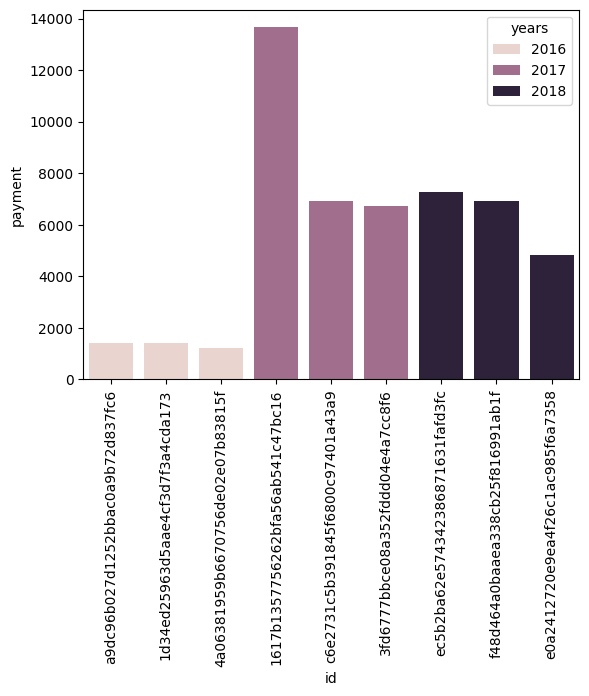

In [66]:
query = """select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,orders.customer_id, sum(payments.payment_value) payment,
dense_rank() over(partition by(year(orders.order_purchase_timestamp)) order by (payments.payment_value)desc) d_rank
from orders join payments
on orders.order_id= payments.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a
where d_rank <=3"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["years","id","payment","rank"])
sns.barplot(x="id",y="payment",data=df,hue="years")
plt.xticks(rotation=90)
plt.show()